# ML Project
Author: *Adam D'Andrea*


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We are going to follow the same workflow as in Lab2: Split data into training and test set. Use the training portion to find the best model using grid search and cross-validation. Evaluate the *winner* on the test set.

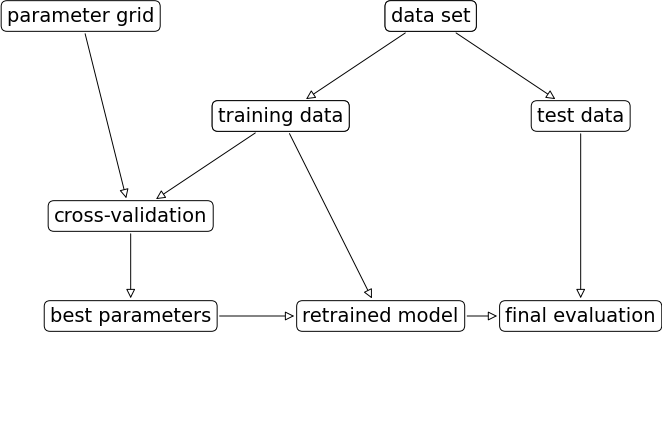

In [3]:
import mglearn
mglearn.plots.plot_grid_search_overview()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate


In [5]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring, cv):
    '''Calculate train and validation score of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
    model.fit(X,y)
    scores = cross_validate(model, X, y, scoring='average_precision', cv=7, return_train_score = True)
    return scores['train_score'].mean(),scores['test_score'].mean()
    

In [6]:
def print_grid_search_result(grid_search):
    '''Prints best parameters and mean training and validation scores of a grid search object.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        scores are printed with 3 decimal places.
        
    '''
        
    print('best parameters {}'.format(grid_search.best_params_))
    
    print('training score {:.3f}'.format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_]))
    
    print('testing score {:.3f}'.format(grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))

In [7]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [8]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    mat = confusion_matrix(y_actual, y_pred, labels = [0, 1])
    
    sns.heatmap(mat, annot=True, cbar=False, fmt='g')
    
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    plt.title('Confusion matrix plot')

## Import Data

In [9]:
import os

In [10]:
#Load in data from csv's
titanic_train = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

# Drop columns that probably will not yeild results, or would have 1 unique value per key
titanic_train = titanic_train.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
#titanic_test = titanic_test.drop(['Name','Ticket','Cabin'], axis=1)

print("training Data Shape is:")
print("rows{} , columns{}".format(titanic_train.shape[0], titanic_train.shape[1]))
titanic_train.head()

training Data Shape is:
rows891 , columns8


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [11]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
print(titanic_train.isnull().sum())
print(titanic_train.columns)
print(titanic_test.columns)
#we have lots of null values for Embarked, Cabin, and Age columns

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Survived      0
dtype: int64
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Survived'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [16]:
#Drop null values. I think we have  enough rows to still have a pretty good analysis. I would rather not taint the data that we have with 177 age guesses
titanic_train=titanic_train.dropna()
titanic_test=titanic_test.dropna()
print(titanic_train.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


In [17]:

y.value_counts()

0    424
1    288
Name: Survived, dtype: int64

In [18]:
X = titanic_train.drop("Survived",axis=1)
y = titanic_train["Survived"]
#X_test  = titanic_test.drop("PassengerId",axis=1).copy()
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(712, 7)
(712,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


## Run OneHotEncoder on Feature Data

In [19]:
# need to use 1 hot encoder to encode values that are not numerical
from sklearn.preprocessing import OneHotEncoder
# Setting sparse=False means OneHotEncode will return a numpy array, not a sparse matrix
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(X)
X_enc = pd.DataFrame(ohe.transform(X), columns=ohe.get_feature_names())
#print(X_enc)
#print("")
#print("The shape of X_enc is:")
print(X_enc.shape)

(712, 328)


In [20]:
X_enc

,x0_1,x0_2,x0_3,x1_female,x1_male,x2_0.42,x2_0.67,x2_0.75,x2_0.83,x2_0.92,...,x5_211.3375,x5_211.5,x5_227.525,x5_247.5208,x5_262.375,x5_263.0,x5_512.3292,x6_C,x6_Q,x6_S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
708,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
709,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
710,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Run Label Encoder on Target Vector (not neded in this case - target alrready an integer representation - but good practice)

In [21]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(y)
y_enc = enc.transform(y)
y_enc

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,

In [22]:
enc.classes_

array([0, 1], dtype=int64)

### Creating Test and Training Data

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size = 0.2, random_state = 37, stratify=y_enc)

## Compare models using Cross-Validation

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

modelNames = ["LogisticRegression", "SVC", "GaussianNB", "RendomForestClassifier","GradientBoostingClassifier"]
modelList = [LogisticRegression(), SVC(),GaussianNB(), RandomForestClassifier(random_state=55),  GradientBoostingClassifier(random_state=56)]


validation_avg_precision_list = []
training_avg_precision_list = []

for model in modelList:
    print("")
    print("Model = " , model)
    train,valid = get_classifier_cv_score(model, X_train, y_train, scoring='accuracy', cv=7)
    validation_avg_precision_list.append(valid)
    training_avg_precision_list.append(train)
    print("VALIDATION score: {:.3f}      |   TRAINING score: {:.3f}".format(valid,train))


Model =  LogisticRegression()
VALIDATION score: 0.828      |   TRAINING score: 0.929

Model =  SVC()
VALIDATION score: 0.830      |   TRAINING score: 0.945

Model =  GaussianNB()
VALIDATION score: 0.457      |   TRAINING score: 0.622

Model =  RandomForestClassifier(random_state=55)
VALIDATION score: 0.812      |   TRAINING score: 0.999

Model =  GradientBoostingClassifier(random_state=56)
VALIDATION score: 0.830      |   TRAINING score: 0.948


In [25]:
for validation_avg_precision, model, training_avg_precision in sorted(list(zip(validation_avg_precision_list,modelList, training_avg_precision_list)),reverse=True):
    print(f'{model}: \n', 'Validation Score: {:.3f}\n'.format(validation_avg_precision), 'Train Score: {:.3f}\n'.format(training_avg_precision))

SVC(): 
 Validation Score: 0.830
 Train Score: 0.945

GradientBoostingClassifier(random_state=56): 
 Validation Score: 0.830
 Train Score: 0.948

LogisticRegression(): 
 Validation Score: 0.828
 Train Score: 0.929

RandomForestClassifier(random_state=55): 
 Validation Score: 0.812
 Train Score: 0.999

GaussianNB(): 
 Validation Score: 0.457
 Train Score: 0.622



## RANDOM FORREST

In [26]:
# Setup grid search for RandomForestClassifier(random_state=55)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model1=RandomForestClassifier(random_state=55)
model1.fit(X_train,y_train)

param_grid = {'n_estimators': [450, 500, 550, 600],'max_depth': [18,19,20,21,22] }

grid1 = GridSearchCV(model1, param_grid, scoring = 'average_precision', cv = 7, n_jobs=4, return_train_score=True)

In [27]:
# perform the grid search by calling fit()
grid1.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55), n_jobs=4,
             param_grid={'max_depth': [18, 19, 20, 21, 22],
                         'n_estimators': [450, 500, 550, 600]},
             return_train_score=True, scoring='average_precision')

In [28]:
# call print_grid_search_result() to print the results
grid1.best_params_ #['average_precision'][grid.best_index_]

{'max_depth': 18, 'n_estimators': 450}

In [29]:
print_grid_search_result(grid1)

best parameters {'max_depth': 18, 'n_estimators': 450}
training score 0.988
testing score 0.836


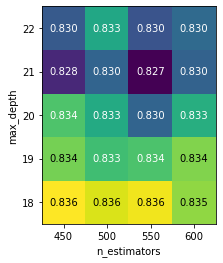

In [30]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid1)

## GRADIENT BOOST

In [31]:
# Setup grid search for GradientBoostingClassifier(max_depth=5, random_state=56)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

model2=GradientBoostingClassifier(max_depth=5, random_state=56)
model2.fit(X_train,y_train)

param_grid = {'n_estimators': [200,250,300,350],'learning_rate': [0.001,0.01,0.1,1.0] }

grid2 = GridSearchCV(model2, param_grid, scoring = 'average_precision', cv = 7, n_jobs=4, return_train_score=True)

In [32]:
# perform the grid search by calling fit()
grid2.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             n_jobs=4,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [200, 250, 300, 350]},
             return_train_score=True, scoring='average_precision')

In [33]:
# call print_grid_search_result() to print the results
print_grid_search_result(grid2)

best parameters {'learning_rate': 0.1, 'n_estimators': 250}
training score 0.997
testing score 0.828


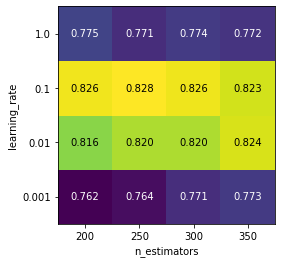

In [34]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid2)

## SVC

In [35]:
# Setup grid search for SVC()
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
model3=SVC()
model3.fit(X_train,y_train)

param_grid = {'C': [0.01, 0.1, 1, 10],'gamma': [0.01, 0.1, 1, 10, 100]}

grid3 = GridSearchCV(model3,param_grid,cv=7,scoring="average_precision",n_jobs=6,return_train_score=True)

In [36]:
# perform the grid search by calling fit()
grid3.fit(X_train,y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=6,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True, scoring='average_precision')

In [37]:
# call print_grid_search_result() to print the results
print_grid_search_result(grid3)

best parameters {'C': 1, 'gamma': 0.01}
training score 0.874
testing score 0.829


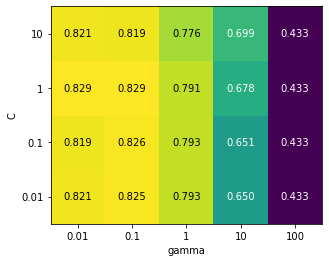

In [38]:
# call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid3)

### Machine Learning Conclusions

Above, you can see that all of the machine learning models (SVC, Gradient Boost, and Random Forrest) preform very well on our data set
with validation scores in the 80%'s and training scores in the 90%'s
However, one model did not work well at all. In the cross validation, we can see that the GaussianNB model had a validation score of 46% and a training score of 62%

## Choose a Good Model - Find a Better Threshold

In [39]:
from sklearn.model_selection import cross_val_predict
cross_val_predict(model1,X_train,y_train,cv=7, method='predict_proba')

array([[0.67, 0.33],
       [0.1 , 0.9 ],
       [0.68, 0.32],
       ...,
       [0.85, 0.15],
       [0.93, 0.07],
       [0.89, 0.11]])

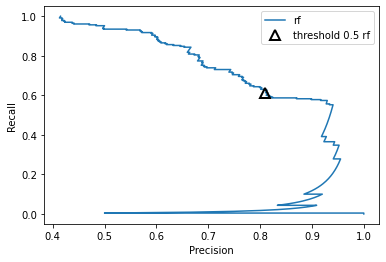

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC

rf = RandomForestClassifier(max_depth=11,n_estimators=700, random_state=55, )
y_train_pred=cross_val_predict(rf,X_train,y_train,cv=7,method='predict_proba')

# RandomForestClassifier has predict_proba, but not decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_train, y_train_pred[:, 1])
close_zero = np.argmin(np.abs(thresholds_rf))



plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

In [41]:
#find a better Threashold
from sklearn.metrics import classification_report
from sklearn.svm import SVC

svc = SVC(gamma=.05).fit(X_train, y_train)

print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        85
           1       0.76      0.64      0.69        58

    accuracy                           0.77       143
   macro avg       0.77      0.75      0.75       143
weighted avg       0.77      0.77      0.77       143



In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, svc.predict(X_test))

array([[73, 12],
       [21, 37]], dtype=int64)

In [43]:
desired_recall = 0.90
idx = np.argwhere(recall_rf>=desired_recall)[-1]
idx

array([206], dtype=int64)

In [44]:
th = np.argwhere(recall_rf>=desired_recall)[-1][0]
th

206

In [45]:
#TODO: Calculate predicted probabilities using cross_val_predict(cv=7, method='predict_proba')
from sklearn.model_selection import cross_val_predict
cross_val_predict(model1,X_train,y_train,cv=7, method='predict_proba')


array([[0.67, 0.33],
       [0.1 , 0.9 ],
       [0.68, 0.32],
       ...,
       [0.85, 0.15],
       [0.93, 0.07],
       [0.89, 0.11]])

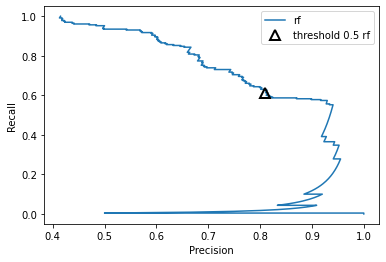

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC

rf = RandomForestClassifier(max_depth=11,n_estimators=700, random_state=55, )
y_train_pred=cross_val_predict(rf,X_train,y_train,cv=7,method='predict_proba')

# RandomForestClassifier has predict_proba, but not decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_train, y_train_pred[:, 1])
close_zero = np.argmin(np.abs(thresholds_rf))



plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

In [47]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC

svc = SVC(gamma=.05).fit(X_train, y_train)

print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        85
           1       0.76      0.64      0.69        58

    accuracy                           0.77       143
   macro avg       0.77      0.75      0.75       143
weighted avg       0.77      0.77      0.77       143



In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, svc.predict(X_test))

array([[73, 12],
       [21, 37]], dtype=int64)

In [49]:
desired_recall = 0.7
idx = np.argwhere(recall_rf>=desired_recall)[-1]
idx

array([340], dtype=int64)

In [50]:
th = np.argwhere(recall_rf>=desired_recall)[-1][0]
th

340

In [51]:
threshHold = thresholds_rf[idx]
threshHold

array([0.44068349])

In [52]:
# retain best model
#TDOD: Retrain random forest classifier
#Retaining RandomForestClassifier(max_depth=11, n_estimators=700, random_state=55)
modelBest = grid1.best_estimator_
modelBest.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, n_estimators=450, random_state=55)

## Evaluation With Default Threashold

In [53]:
ranForest = modelBest.fit(X_train, y_train)

In [54]:
# print classification report using default threshold
from sklearn.metrics import accuracy_score

y_pred = (modelBest.predict_proba(X_test)[:,1] >=threshHold).astype(bool)
print(classification_report(y_test, y_pred,target_names=["doesnt survive", "survives"]))

                precision    recall  f1-score   support

doesnt survive       0.80      0.92      0.85        85
      survives       0.84      0.66      0.74        58

      accuracy                           0.81       143
     macro avg       0.82      0.79      0.80       143
  weighted avg       0.82      0.81      0.81       143



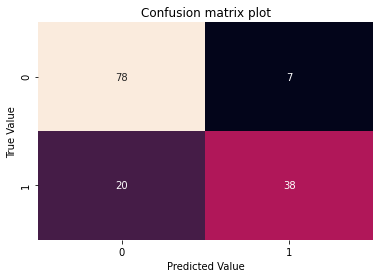

In [55]:
# call plot_confusion_matrix()
import matplotlib.pyplot as plt  # doctest: +SKIP

plot_confusion_matrix(y_test, y_pred, [0,1])

## Evaluation With New Threashold

In [56]:
# print classification report using new threshold
from sklearn.metrics import classification_report
print(classification_report(y_test, modelBest.predict(X_test),target_names=["doesnt survive", "survives"]))

                precision    recall  f1-score   support

doesnt survive       0.77      0.92      0.84        85
      survives       0.83      0.60      0.70        58

      accuracy                           0.79       143
     macro avg       0.80      0.76      0.77       143
  weighted avg       0.80      0.79      0.78       143



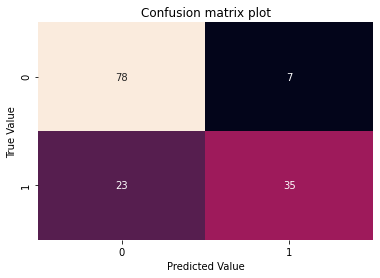

In [57]:
# call plot_confusion_matrix()
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(y_test, modelBest.predict(X_test), [0,1])

### Threshold Conclusions

By tailoring the threshold, we can acheive a overall accuracy of 83% for predicting if a passenger will survive or not on the titanic.
We are also have a f1 score of 87% for predicting if someone will not survive
and a 75% chance of predicting if someone will survive

However, as you can see in the confusion matrix above, there is a still a chance for us to inncorectly guess if someone will or will not survive

# RESULTS

In [97]:
# print classification report using new threshold
from sklearn.metrics import classification_report
print(classification_report(y_test, modelBest.predict(X_test),target_names=["doesnt survive", "survives"]))

                precision    recall  f1-score   support

doesnt survive       0.77      0.92      0.84        85
      survives       0.83      0.60      0.70        58

      accuracy                           0.79       143
     macro avg       0.80      0.76      0.77       143
  weighted avg       0.80      0.79      0.78       143



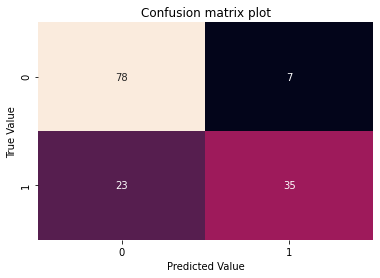

In [98]:
# call plot_confusion_matrix()
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(y_test, modelBest.predict(X_test), [0,1])

In [99]:
print_grid_search_result(grid1)

best parameters {'max_depth': 18, 'n_estimators': 450}
training score 0.988
testing score 0.836


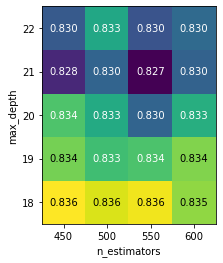

In [100]:
plot_grid_search_results(grid1)



## Extra Plots for Interpretation

#### Note: This is after removing rows with no age. it's a little less accurate, but let's assume that that is a random occurance, so if the rows are removed, it should be evenly distributed between features (men/women, age's, survival, etc)

Text(0.5, 1.0, 'Death vs. Survival Count')

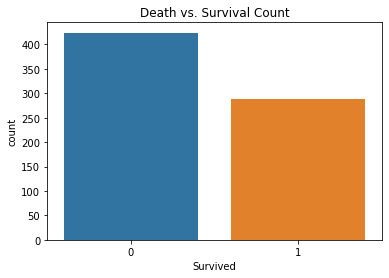

In [74]:
import seaborn as sns
sns.countplot(x="Survived", data=titanic_train).set_title('Death vs. Survival Count')

Text(0.5, 1.0, 'Death vs. Survival Count for Males and Females')

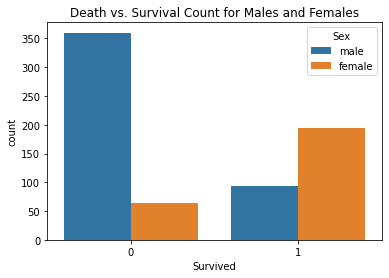

In [75]:
sns.countplot(x="Survived", hue = 'Sex', data=titanic_train).set_title('Death vs. Survival Count for Males and Females')
#wp,em had a far greater survival change - I am pretty sure women and children got preference for the life boats. the men who survived are probably mostly young boys
# lets check in the next figure

Text(0.5, 1.0, 'Age Frequency')

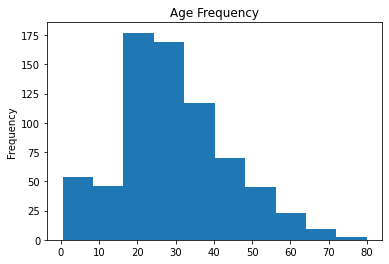

In [77]:
titanic_train['Age'].plot.hist().set_title('Age Frequency')

Text(0.5, 1.0, 'Survival and Death Count vs Class Type')

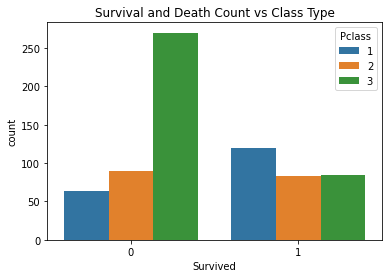

In [78]:
sns.countplot(x = "Survived", hue = "Pclass", data = titanic_train).set_title('Survival and Death Count vs Class Type')
#3rd class passengers seemed to have the higher survival chance

Text(0.5, 1.0, 'Frequency of Fare Cost')

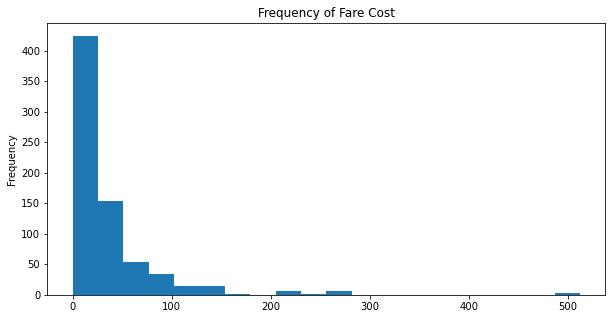

In [79]:
titanic_train['Fare'].plot.hist(bins = 20, figsize = (10,5)).set_title('Frequency of Fare Cost')
#not only was it the 3rd class passengers who survived more often, but also the passengers who has a 'lower fare' - these two features are related

Text(0.5, 1.0, 'Sibling Types vs Count')

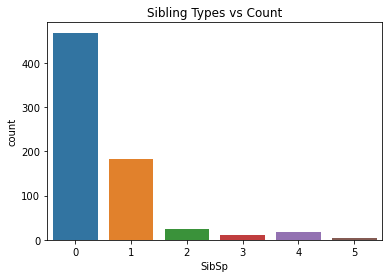

In [80]:
sns.countplot(x= "SibSp", data = titanic_train).set_title('Sibling Types vs Count')

[Text(0, 0, 'With Family'), Text(0, 0, 'Alone')]

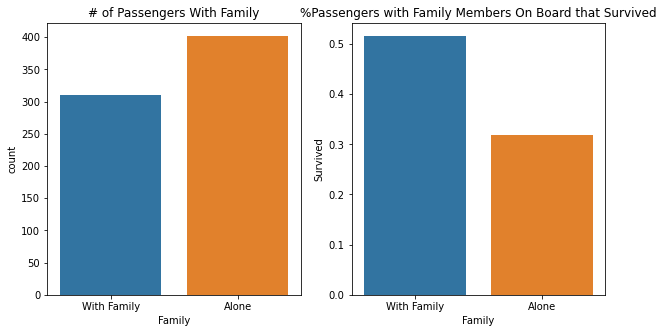

In [86]:
# make changes with training dataset
titanic_train['Family'] =  titanic_train["Parch"] + titanic_train["SibSp"]
titanic_train['Family'].loc[titanic_train['Family'] > 0] = 1
titanic_train['Family'].loc[titanic_train['Family'] == 0] = 0

# make changes with test dataset
titanic_test['Family'] =  titanic_test["Parch"] + titanic_test["SibSp"]
titanic_test['Family'].loc[titanic_test['Family'] > 0] = 1
titanic_test['Family'].loc[titanic_test['Family'] == 0] = 0

# Plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_train,kind='count',ax=axis1)
sns.countplot(x='Family', data=titanic_train, order=[1,0], ax=axis1).set_title('# of Passengers With Family')

# average of survived for those who had/didn't have any family member
family_perc = titanic_train[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2).set_title('%Passengers with Family Members On Board that Survived')

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

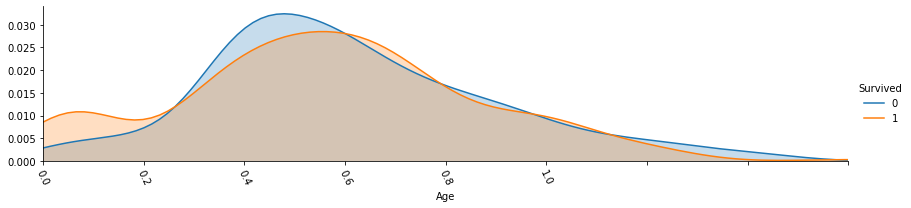

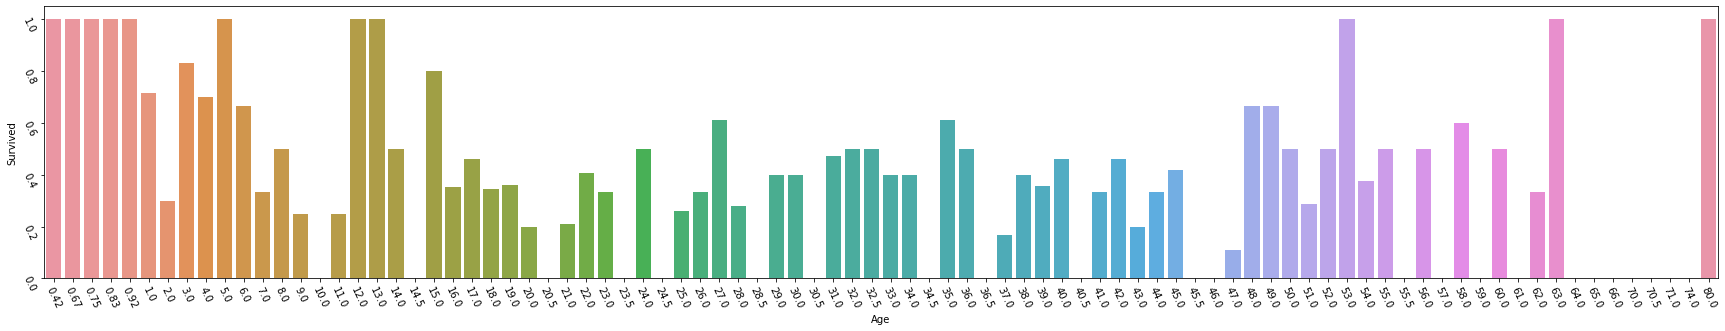

In [93]:
# Age of passengers vs their frequency

facet = sns.FacetGrid(titanic_train, hue="Survived",aspect=4)
facet.set_xticklabels(rotation=295)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_train['Age'].max()))
facet.add_legend()
# Survival rate vs Age

fig, axis1 = plt.subplots(1,1,figsize=(30,5))
plt.tick_params(rotation=295)
avg_age = titanic_train[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=avg_age)


Text(0.5, 1.0, 'Survival Rate vs Embarkment Location')

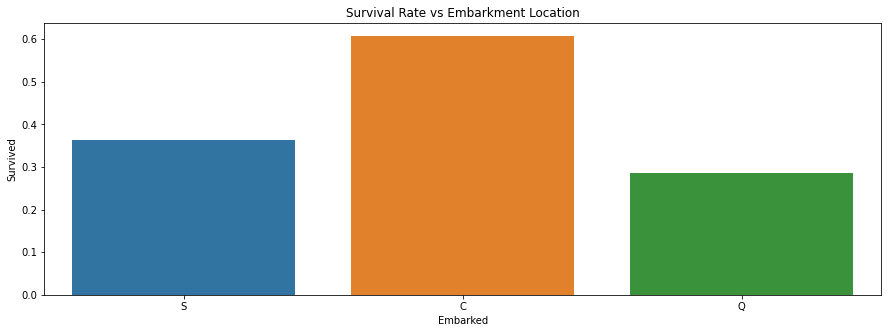

In [96]:
#Embarkment Location, vs Survival rate ( out of 1)

fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
embark_perc = titanic_train[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis1).set_title('Survival Rate vs Embarkment Location')

# FINAL CONCLUSIONS

  This code ran smoother than expected, and the final validation and testing scores are very high:
  
  Cross validation determined the following:
  
  SVC: Valdiation Score = 0.830 ; Training Score = 0.945
  Gradient Boosting: Valdiation Score = 0.830 ; Training Score = 0.948
  Logistic Regression: Valdiation Score = 0.828 ; Training Score = 0.929
  Random Forest: Valdiation Score = 0.812 ; Training Score = 0.999
  Gaussian NB: Valdiation Score = 0.457 ; Training Score = 0.622
  
  Then after running a Grid Search on each of the models, the following scores were obtained:
  
  SVC: Valdiation Score = 0.829 ; Training Score = 0.874
  Gradient Boosting: Valdiation Score = 0.828 ; Training Score = 0.997
  Logistic Regression: Valdiation Score = 0.828 ; Training Score = 0.929
  Random Forest: Valdiation Score = 0.836 ; Training Score = 0.988
  Gaussian NB: Thrown out
  
  Above, the Random Forest performed very well, with the highest validations scores.
  So we used Random Forest to further refine our accuracy/percision using various thresholds
  In the end, a nice balance was found, giving us a final survival F1 score of 75%, and a does NOT survive F1 score of 87%.
  Accuracy, precision and recall are all relativly high:
  
  Deos NOT Survive (precision = 0.84, recall = 0.87)
  Does Survive (precision = 0.80, recall = 0.70)
  and a Accuracy of 83%
  

# INTERPRETATION

    Above, the Random Forest performed very well, with the highest validations scores.
  So we used Random Forest to further refine our accuracy/percision using various thresholds
  In the end, a nice balance was found, giving us a final survival F1 score of 75%, and a does NOT survive F1 score of 87%.
  Accuracy, precision and recall are all relativly high:
  
  Deos NOT Survive (precision = 0.84, recall = 0.87)
  Does Survive (precision = 0.80, recall = 0.70)
  and a Accuracy of 83%
  
  From further investigation with figures, it can be determined that young children and women were let on the life boats first, resulting in drastically more women and children surviving the incident.
  
  
  Also, lots of Class 3 passengers did not survive (~ 2.5 times more than class 1 and 2 passengers), however an equal amount of class 1,2 and 3 survived. This tells us that there simply are more class 3 passengers than any other type.
  But that the life-boats took an even number from each passenger class.

  It does appear as though the passengers whom embarked from "C" (Cherbourg) had a higher chance of survival, however, I stuggle to come up with an explination for this, appart from them maybe having more children or women ( a female birthday party or something) on board

# REFLECTIONS

   
-Suprisingly, I was able to stay on track with my project proposal. The titanic code ran relatively smoothly when I applied Lab3 trechniques to it

-I was also able to impliment a couple extra firgures for analytical interpretation.
   
   From further investigation with figures, it can be determined that young children and women were let on the life boats first, resulting in drastically more women and children surviving the incident.
  (it would be interesting to see how accurate out Machine Learning algorythms can predict the outcome of a massenger, if the "sex" column was removed from the feature list)
    
  I have a feeling that the machine learning model mainly determined its classification as "survived" or "not" from the 'Sex" class. As most women and children were let on the life boats first. I would be very curious how accurate the model is at determining if a passenger will survive or not IF the 'Sex' feature column was removed. However, I do not want to make this project longer than is necessary, but it would be a simple proecess to check.
  
  -I would also like to thank the University of Calgary, and Yves Pauchard. As I re-used lots of code that we had done in his Machine Learning class, and tailored it for this Titanic Kaggle competition.

  I tried to print out 'feature importance' in a nice plot, but I was having trouble with the output
  I removed blank "age" rows from the data set, this reduces our data set, however I thought the trade off of loosing some rows of data was worth maintaining the 'purity' of the data set by NOT averageing age values to fill in the blank's. However, I supposed before dropping these rows, I should had done the data analytics of the features that do not involved 'Age' first.